<a href="https://colab.research.google.com/github/KunChen-tw/DeepLearning/blob/main/deeplearning1109_Ch7_5_2330TW_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The comparison between RNN and LSTM via financial data(1)


In [1]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
torch.manual_seed(18)

# Step 1: Download financial data
data = yf.download("2330.TW", start="2021-01-01", end="2024-01-01")
prices = data['Close'].values.astype(float)

# Step 2: Preprocess the data
scaler = MinMaxScaler(feature_range=(-1, 1))
prices_normalized = scaler.fit_transform(prices.reshape(-1, 1))


[*********************100%***********************]  1 of 1 completed


# The comparison between RNN and LSTM via financial data(2)

In [2]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Use past 30 days to predict the next day
x_data, y_data = create_sequences(prices_normalized, seq_length)



# The comparison between RNN and LSTM via financial data(3)


In [3]:
# Split into training and testing data
train_size = int(len(x_data) * 0.8)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Convert data to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
x_test = torch.from_numpy(x_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)


# Define the RNN model


In [6]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the models
# Instantiate the models and move them to device
rnn_model = RNNModel().to(device)

!pip install torchinfo
from torchinfo import summary
print(summary(rnn_model))


Layer (type:depth-idx)                   Param #
RNNModel                                 --
├─RNN: 1-1                               4,288
├─Linear: 1-2                            65
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0


# Define the LSTM model

In [7]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the models
lstm_model = LSTMModel().to(device)
print(summary(lstm_model))


Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              17,152
├─Linear: 1-2                            65
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0


# Training RNN and LSTM model

In [8]:
# Set up optimizers and loss function
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.01)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.05)
criterion = nn.MSELoss()

# Training function
def train_model(model, optimizer, x_train, y_train, epochs=1000):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

print("Training RNN Model...")
train_model(rnn_model, rnn_optimizer, x_train, y_train)

print("Training LSTM Model...")
train_model(lstm_model, lstm_optimizer, x_train, y_train)


Training RNN Model...
Epoch 20, Loss: 0.010309059172868729
Epoch 40, Loss: 0.005902769044041634
Epoch 60, Loss: 0.003996990621089935
Epoch 80, Loss: 0.003759297076612711
Epoch 100, Loss: 0.003639131784439087
Epoch 120, Loss: 0.00355072901584208
Epoch 140, Loss: 0.0034769405610859394
Epoch 160, Loss: 0.003416502382606268
Epoch 180, Loss: 0.0033677543979138136
Epoch 200, Loss: 0.003328411839902401
Epoch 220, Loss: 0.0032954057678580284
Epoch 240, Loss: 0.003270001383498311
Epoch 260, Loss: 0.00325494515709579
Epoch 280, Loss: 0.003245782572776079
Epoch 300, Loss: 0.003239903599023819
Epoch 320, Loss: 0.0032353829592466354
Epoch 340, Loss: 0.003231184557080269
Epoch 360, Loss: 0.0032268352806568146
Epoch 380, Loss: 0.003222192870453
Epoch 400, Loss: 0.0032173707149922848
Epoch 420, Loss: 0.003212696872651577
Epoch 440, Loss: 0.0032085669226944447
Epoch 460, Loss: 0.003205186454579234
Epoch 480, Loss: 0.0032024660613387823
Epoch 500, Loss: 0.003200181759893894
Epoch 520, Loss: 0.0031981447

# Evaluation function

In [9]:
# Evaluation function
def evaluate_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test)
        loss = criterion(predictions, y_test)
    return predictions, loss.item()

# Evaluate both models
rnn_predictions, rnn_loss = evaluate_model(rnn_model, x_test, y_test)
lstm_predictions, lstm_loss = evaluate_model(lstm_model, x_test, y_test)

print(f'RNN Test Loss: {rnn_loss}')
print(f'LSTM Test Loss: {lstm_loss}')


RNN Test Loss: 0.0018920272123068571
LSTM Test Loss: 0.0018173499265685678


# Show figure

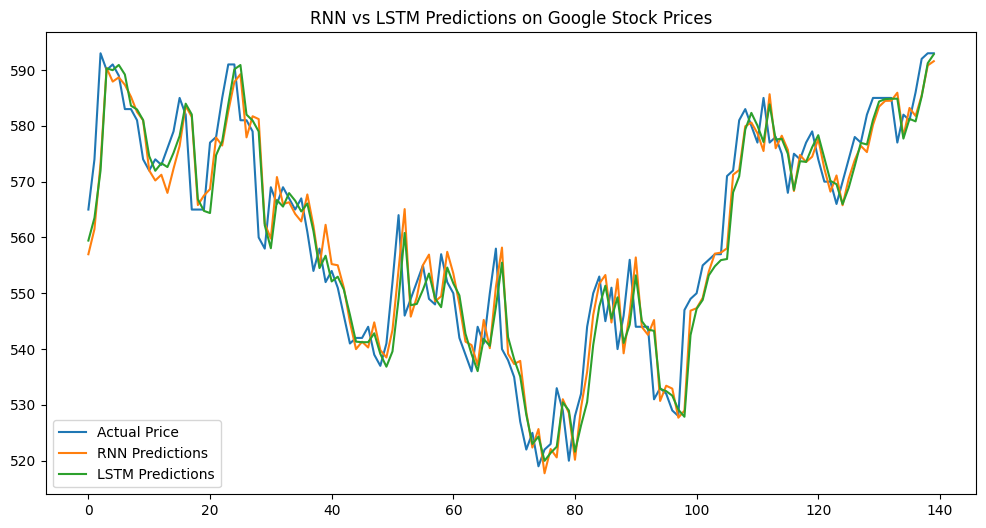

In [10]:
# Inverse transform the predictions to original scale
rnn_predictions = scaler.inverse_transform(rnn_predictions.cpu().numpy())
lstm_predictions = scaler.inverse_transform(lstm_predictions.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Price")
plt.plot(rnn_predictions, label="RNN Predictions")
plt.plot(lstm_predictions, label="LSTM Predictions")
plt.legend()
plt.title("RNN vs LSTM Predictions on Google Stock Prices")
plt.show()
